In [1]:
%load_ext autoreload
%autoreload 2

import os 
import sys
import skimage.draw
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")


In [135]:
dataset = "/allen/programs/celltypes/workgroups/em-connectomics/gayathrim/nuclei_segmentation/data/maskrcnn"
weights = "/allen/programs/celltypes/workgroups/em-connectomics/gayathrim/nuclei_segmentation/logs/nuclei20190811T1750/mask_rcnn_nuclei_0160.h5"
logs = "/allen/programs/celltypes/workgroups/em-connectomics/gayathrim/nuclei_segmentation/logs"
command = "test"
image = "/allen/programs/celltypes/workgroups/em-connectomics/gayathrim/nuclei_segmentation/data/maskrcnn/val/images/data_19_2.png"

In [136]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR) 

from mrcnn import model as modellib, utils, visualize
from nuclei import NucleiDataset, NucleiConfig, NucleiInferenceConfig


# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")


# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")


def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a 
    central point to control graph sizes.

    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax


In [137]:

def test(model, image_path):
    print("Running on {}".format(image_path))
    
    # Read image
    image = skimage.io.imread(image_path)
    image = skimage.color.gray2rgb(image)
    print(image.shape)
    # Remove alpha channel, if it has one
    if image.shape[-1] == 4:
        image = image[..., :3]

    # detect objects
    r = model.detect([image], verbose=1)[0]

    # Display results
    ax = get_ax(1)
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],
                                ["Background", "nuclei"], r['scores'], ax=ax,
                                title="Predictions")



In [138]:
# Configurations
print(command)
if command == "train":
    config = NucleiConfig()
else:
    class InferenceConfig(NucleiInferenceConfig):
        # Set batch size to 1 since we'll be running inference on
        # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
        GPU_COUNT = 1
        IMAGES_PER_GPU = 1
        IMAGE_MIN_DIM = 256
        IMAGE_RESIZE_MODE = "none"
        DETECTION_MIN_CONFIDENCE = 0.7
    config = InferenceConfig()
config.display()

# Create model
if command == "train":
    model = modellib.MaskRCNN(mode="training", config=config,
                              model_dir=logs)
else:
    model = modellib.MaskRCNN(mode="inference", config=config,
                              model_dir=logs)

weights_path = weights

# Load weights
print("Loading weights ", weights_path)
# Exclude the last layers because they require a matching
# number of classes
model.load_weights(weights_path, by_name=True)


test

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_IN

Running on /allen/programs/celltypes/workgroups/em-connectomics/gayathrim/nuclei_segmentation/data/maskrcnn/val/images/data_19_2.png
(256, 256, 3)
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  236.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  132.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -1.41976  max:    2.16878  float32

*** No instances to display *** 



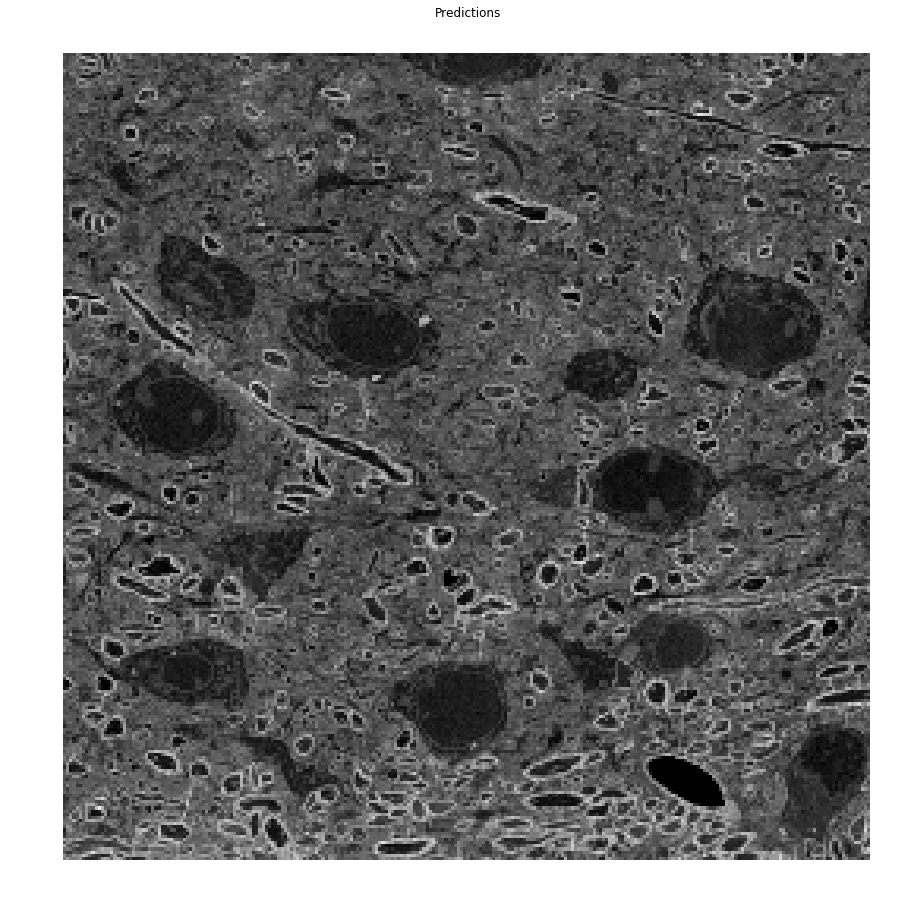

In [139]:

# Train or evaluate
if command == "train":
    train(model, dataset)
elif command == "test":
    test(model, image_path=image)
else:
    print("'{}' is not recognized. "
          "Use 'train' or 'test'".format(command))